# Covid Severity Classifier
- A Machine Learning system to predict the severity of a patient's Covid-19 based on their symptoms
- Created with the [Kaggle Covid-19 Patient Symptoms](https://www.kaggle.com/bitsofishan/covid19-patient-symptoms) dataset
- It preprocesses the data
- Defines a Deep Neural Network model in Tensorflow
- Trains the Machine Learning model
- And outputs the model and some required data to be used in a Django web application

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-patient-symptoms/COVID-19.xlsx


In [3]:
!pip install openpyxl
!pip install missingno

     |████████████████████████████████| 243 kB 596 kB/s eta 0:00:01


In [4]:
import openpyxl
import missingno as msno
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load the Data

In [8]:
raw_df = pd.read_excel('../input/covid19-patient-symptoms/COVID-19.xlsx')
raw_df.head()

,Sno,age,gender,body temperature,Dry Cough,sour throat,weakness,breathing problem,drowsiness,pain in chest,...,stroke or reduced immunity,symptoms progressed,high blood pressue,kidney disease,change in appetide,Loss of sense of smell,Corona result,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,1,20,1,98.6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2,19,1,99.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,3,55,0,102.0,1,1,1,1,1,1,...,0,0,0,0,1,0,1,NaN,NaN,NaN
3,4,40,0,100.0,0,0,0,0,1,1,...,0,1,1,0,1,0,2,NaN,NaN,NaN
4,5,33,1,99.2,0,1,0,1,0,0,...,1,1,0,0,0,1,2,NaN,NaN,NaN


# Exploratory Data Analysis
- Analyze the data to figure out what needs to be done to it before it can be used for machine learning

<AxesSubplot:>

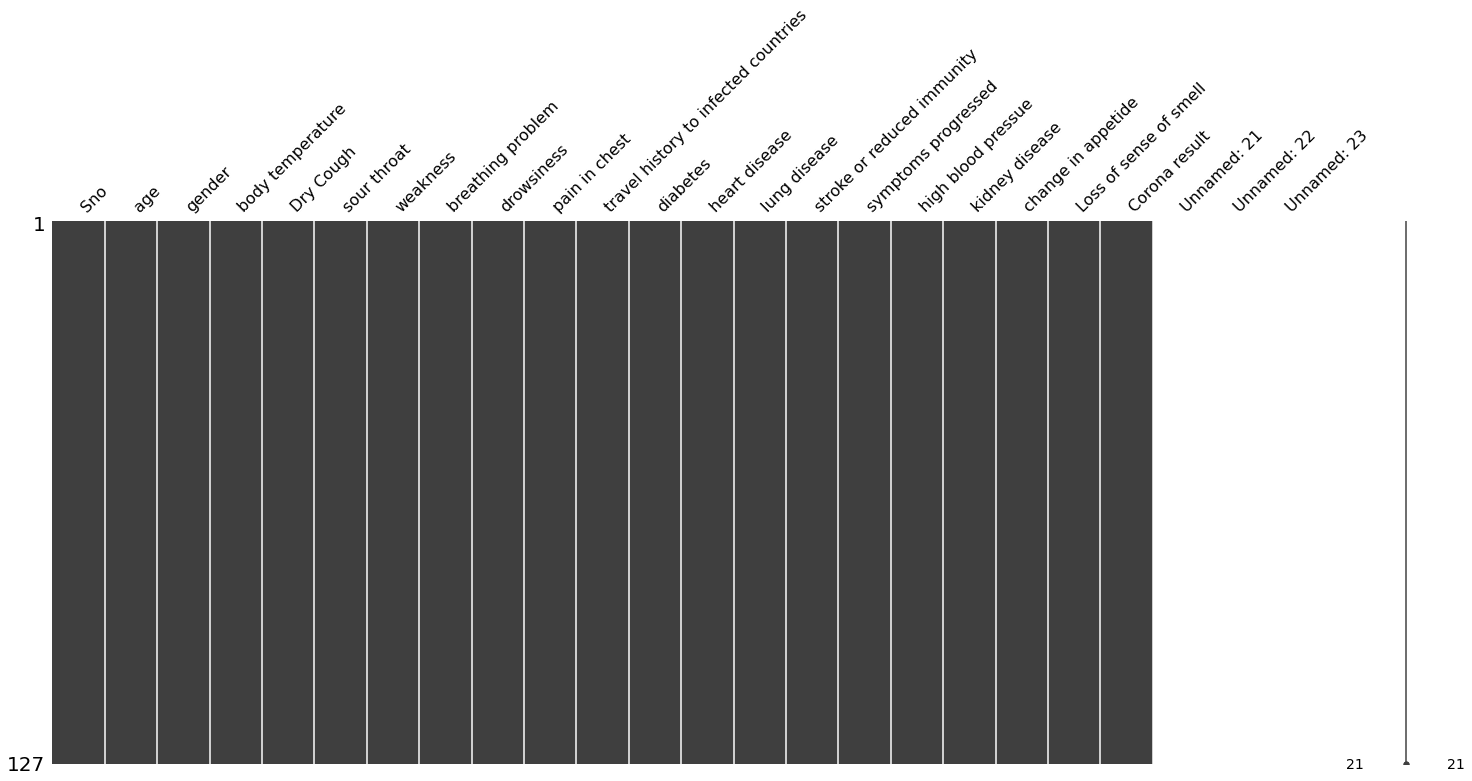

In [9]:
msno.matrix(raw_df)

In [10]:
for i in raw_df.columns:
    print(f"column name: {i}, unique values: {len(raw_df[i].unique())}")

column name: Sno, unique values: 127
column name: age, unique values: 48
column name: gender, unique values: 2
column name: body temperature, unique values: 29
column name: Dry Cough, unique values: 2
column name: sour throat, unique values: 2
column name: weakness, unique values: 2
column name: breathing problem, unique values: 2
column name: drowsiness, unique values: 2
column name: pain in chest, unique values: 2
column name: travel history to infected countries, unique values: 2
column name: diabetes, unique values: 2
column name: heart disease, unique values: 2
column name: lung disease, unique values: 2
column name: stroke or reduced immunity, unique values: 2
column name: symptoms progressed, unique values: 2
column name: high blood pressue, unique values: 2
column name: kidney disease, unique values: 2
column name: change in appetide, unique values: 2
column name: Loss of sense of smell, unique values: 2
column name: Corona result, unique values: 3
column name: Unnamed: 21, uni

# Data Preprocessing
## Missing Values
- all columns are good, with no missing values
- Except for `Unnamed: 21`, `Unnamed: 22` and `Unnamed: 23`
- We'll remove them because they won't help the final model

## Relevant Columns
- `Corona result` is the severity of the patients covid symptoms
- `Sno, gender, and body temperature` are not relevant for our model or difficult to ask

## Scaling
- All columns we will use are categorical except for age
- So leave all columns as they are except for age
- Normalize age with min max scaling
- Store minimum and maximum so web app can scale age appropriately as well

## Conclusion
- So we will drop the columns `Unnamed: 21, Unnamed: 22, Unnamed: 23, Sno, Gender and body temperature`

In [11]:
less_data = raw_df.drop(['Sno','Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'gender', 'body temperature'], axis=1)
less_data.head()

,age,Dry Cough,sour throat,weakness,breathing problem,drowsiness,pain in chest,travel history to infected countries,diabetes,heart disease,lung disease,stroke or reduced immunity,symptoms progressed,high blood pressue,kidney disease,change in appetide,Loss of sense of smell,Corona result
0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,19,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,55,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,1
3,40,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,0,2
4,33,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1,2


In [12]:
# Min-Max Normalization
age_min = min(raw_df["age"])
age_max = max(raw_df["age"])
target_min = min(raw_df["Corona result"])
target_max = max(raw_df["Corona result"])
print(age_min, age_max)
print(target_min, target_max)

18 80
0 2


In [13]:
def min_max_scaling(min_val, max_val, df, col_name):
    def min_max_scale_val(val):
        return (val - min_val) / (max_val - min_val)
    return df.apply(lambda x: min_max_scale_val(x) if x.name == col_name else x)

In [14]:
scaled_data = min_max_scaling(age_min, age_max, less_data, "age")
scaled_data = min_max_scaling(target_min, target_max, scaled_data, "Corona result")
scaled_data.head()

,age,Dry Cough,sour throat,weakness,breathing problem,drowsiness,pain in chest,travel history to infected countries,diabetes,heart disease,lung disease,stroke or reduced immunity,symptoms progressed,high blood pressue,kidney disease,change in appetide,Loss of sense of smell,Corona result
0,0.032258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,0.016129,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,0.596774,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0.5
3,0.354839,0,0,0,0,1,1,1,1,0,0,0,1,1,0,1,0,1.0
4,0.241935,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1,1.0


In [97]:
print(scaled_data.columns)

Index(['age', 'Dry Cough', 'sour throat', 'weakness', 'breathing problem',
       'drowsiness', 'pain in chest', 'travel history to infected countries',
       'diabetes', 'heart disease', 'lung disease',
       'stroke or reduced immunity', 'symptoms progressed',
       'high blood pressue', 'kidney disease', 'change in appetide',
       'Loss of sense of smell'],
      dtype='object')


In [98]:
scores = {
    "age": 7,
    "Dry Cough": 2,
    "sour throat": 1,
    "weakness": 4,
    "breathing problem": 7,
    "drowsiness": 3,
    "pain in chest" : 8,
    "travel history to infected countries": 5,
    "diabetes": 6,
    "heart disease": 8,
    "lung disease": 10,
    "stroke or reduced immunity": 10,
    "symptoms progressed": 7,
    "high blood pressue": 6,
    "kidney disease": 7, 
    "change in appetide": 2,
    "Loss of sense of smell": 1,
}
print(len(scores) == len(scaled_data.columns))

True


In [118]:
for key in scores:
    scores[key] /= 10
scores

{'age': 0.7,
 'Dry Cough': 0.2,
 'sour throat': 0.1,
 'weakness': 0.4,
 'breathing problem': 0.7,
 'drowsiness': 0.3,
 'pain in chest': 0.8,
 'travel history to infected countries': 0.5,
 'diabetes': 0.6,
 'heart disease': 0.8,
 'lung disease': 1.0,
 'stroke or reduced immunity': 1.0,
 'symptoms progressed': 0.7,
 'high blood pressue': 0.6,
 'kidney disease': 0.7,
 'change in appetide': 0.2,
 'Loss of sense of smell': 0.1}

In [119]:
def heurestic_score(data):
    score = 0
    for i in range(len(list(scores))):
        this_symptom = list(scores.keys())[i]
        score += data[i] * scores[this_symptom]
    return score

In [121]:
heurestic_scores = []
for i in range(len(scaled_data)):
    this_data = list(scaled_data.iloc[i])
    this_score = heurestic_score(this_data)
    heurestic_scores.append(this_score)
heurestic_scores[:10]

[0.02258064516129032,
 0.21129032258064517,
 3.1177419354838714,
 3.948387096774194,
 4.269354838709677,
 3.8725806451612903,
 8.599999999999998,
 1.4838709677419353,
 4.095161290322581,
 1.3064516129032258]

In [125]:
max_heurestic_score = max(heurestic_scores)
min_heurestic_score = min(heurestic_scores)
scaled_heurestic_scores = []
for i in range(len(heurestic_scores)):
    def scale_heurestic_score(score):
        return score / max_heurestic_score
    scaled_heurestic_scores.append(scale_heurestic_score(heurestic_scores[i]))
print(scaled_heurestic_scores[:20])

[0.0026256564141035263, 0.024568642160540142, 0.3625281320330084, 0.4591147786946738, 0.4964366091522881, 0.4503000750187548, 1.0, 0.172543135783946, 0.47618154538634677, 0.15191297824456118, 0.10802700675168794, 0.29538634658664675, 0.38972243060765205, 0.21661665416354092, 0.4039759939984997, 0.4866841710427608, 0.6275318829707429, 0.059077269317329345, 0.39759939984996256, 0.7477494373593401]


In [21]:
target = scaled_data.pop('Corona result', in_place)
target.head()

0    0.0
1    0.0
2    0.5
3    1.0
4    1.0
Name: Corona result, dtype: float64

In [126]:
scaled_data.insert(0, "heurestic score", scaled_heurestic_scores)

In [130]:
shuffled_data = scaled_data.sample(frac = 1)
shuffled_data.head()

,heurestic score,age,Dry Cough,sour throat,weakness,breathing problem,drowsiness,pain in chest,travel history to infected countries,diabetes,heart disease,lung disease,stroke or reduced immunity,symptoms progressed,high blood pressue,kidney disease,change in appetide,Loss of sense of smell
109,0.447487,0.354839,0,0,1,1,1,0,0,1,0,0,0,1,1,0,1,1
125,0.316767,0.177419,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1
105,0.208177,0.129032,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
55,0.258440,0.032258,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1
110,0.188860,0.177419,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1


# Tensorflow Data Pipeline
- Create a data pipeline to transform the data so it can be used to train the Machine Learning model

In [131]:
dataset = tf.data.Dataset.from_tensor_slices((shuffled_data.values, target.values))

In [132]:
train_dataset = dataset.shuffle(len(shuffled_data)).batch(1)

# Define Model
- Define the architecture and training strategy of the deep learning model
- We are using a straight-forward deep learning model with 21 layers
- Training will use accuracy as the main metric

In [133]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

# Train Model

In [134]:
model = get_compiled_model()
history = model.fit(train_dataset, epochs=15)

Epoch 1/15
127/127 [==============================] - 1s 1ms/step - loss: 0.7215 - accuracy: 0.2579
Epoch 2/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6954 - accuracy: 0.2639
Epoch 3/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6814 - accuracy: 0.2500
Epoch 4/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.2385
Epoch 5/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.2139
Epoch 6/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6727 - accuracy: 0.3041
Epoch 7/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6648 - accuracy: 0.3296
Epoch 8/15
127/127 [==============================] - 0s 2ms/step - loss: 0.6725 - accuracy: 0.2933
Epoch 9/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.3273
Epoch 10/15
127/127 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.2974

# Analyze Model

In [92]:
test_dataset = model.evaluate(dataset.batch(1))

127/127 [==============================] - 0s 1ms/step - loss: 0.5153 - accuracy: 0.4409


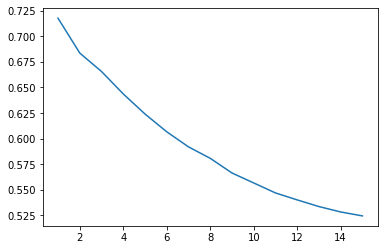

In [47]:
plt.plot([i + 1 for i in range(15)], history.history['loss'])

In [73]:
min_pred = float("inf")
max_pred = -float("inf")
for i in scaled_data.values:
    this_pred = model.predict(tf.reshape(list(i), (1, 17)))
    if this_pred < min_pred:
        min_pred = this_pred
    elif this_pred > max_pred:
        max_pred = this_pred
print(min_pred, max_pred)

[[-3.1807234]] [[2.8405762]]


In [ ]:
scaled_data.values

In [81]:
pred_range = (max_pred - min_pred)[0][0]
category_size = (pred_range / 3)
print(pred_range, category_size)

6.0212994 2.0070997873942056


In [83]:
def predict_severity(inp):
    '''
    - given a list containing a Patient's symptoms
    - predict the severity of their disease
    - from 0 as least severe, to 2 as most severe
    '''
    this_pred = model.predict(tf.reshape(list(inp), (1, 17)))[0][0]
    category = -1
    if this_pred < min_pred + category_size:
        category = 0
    elif this_pred >= min_pred + category_size and this_pred <= max_pred - category_size:
        category = 1
    else:
        category = 2
    return category

In [84]:
for i in scaled_data.values:
    print( predict_severity(i), end=" ,")

0 ,0 ,1 ,2 ,2 ,2 ,2 ,1 ,1 ,0 ,1 ,1 ,0 ,0 ,0 ,1 ,2 ,0 ,1 ,2 ,1 ,0 ,0 ,1 ,1 ,1 ,1 ,1 ,2 ,2 ,2 ,1 ,2 ,1 ,1 ,1 ,1 ,1 ,2 ,1 ,0 ,0 ,1 ,1 ,1 ,2 ,1 ,1 ,2 ,2 ,1 ,2 ,1 ,0 ,1 ,2 ,0 ,2 ,2 ,1 ,0 ,0 ,1 ,2 ,1 ,2 ,0 ,1 ,1 ,1 ,0 ,0 ,1 ,1 ,0 ,1 ,2 ,1 ,0 ,1 ,1 ,1 ,1 ,1 ,0 ,0 ,1 ,2 ,0 ,2 ,1 ,2 ,1 ,2 ,0 ,0 ,0 ,0 ,1 ,1 ,0 ,1 ,1 ,1 ,0 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,1 ,2 ,1 ,1 ,1 ,1 ,0 ,1 ,0 ,1 ,1 ,1 ,2 ,

In [87]:
model.save('/kaggle/working/model')

In [89]:
import shutil
shutil.make_archive('/kaggle/working/model', 'zip', '/kaggle/working/model')

'/kaggle/working/model.zip'

# Conclusions
- We were able to get a pretty good model with very little data
- It is twice as good as guessing randomly on this problem
- However, we need more data to create a good enough model for any practical use
- This is just a proof of concept